# Proyecto BI - Entrega 1

## Integrantes - Grupo 15

- Sara Sofia Cárdenas Rodríguez - 202214907
- Daniel Felipe Diaz Moreno - 202210773
- Juan Sebastián Urrea López - 201914710

## Objetivo

- Aplicar la metodología de analítica de textos para la construcción de soluciones de
analítica alineadas con los objetivos de organizaciones en un contexto de aplicación

## Caso de Negocio: Fondo de Poblaciones de las Naciones Unidas

El Fondo de Poblaciones de las Naciones Unidas (UNFPA) junto con entidades públicas y haciendo uso de diferentes herramientas de participación ciudadana, busca identificar problemas y evaluar soluciones actuales, relacionando la información dada por los ciudadanos con los diferentes Objetivos de Desarrollo Sostenible (ODS). Los ODS fueron adoptados por las Naciones Unidas en 2015 como un llamamiento universal para poner fin a la pobreza, proteger el planeta y garantizar que para el 2030 todas las personas disfruten de paz y prosperidad.

En este contexto, uno de los procesos que requiere mayor esfuerzo es el análisis de la información textual recopilada, ya que consume muchos recursos, que incluyen la participación de un experto. Es así como el UNFPA quiere desarrollar un proyecto con ustedes, donde el objetivo principal es relacionar de forma automática opiniones de los ciudadanos con los ODS 3, 4 y 5. A nivel de la solución a plantear, deben aplicar la metodología de desarrollo de aplicaciones analíticas para crear un modelo analítico que sea utilizado y reentrenado por medio de una aplicación web o móvil a partir de un conjunto de opiniones que contienen texto en lenguaje natural.

## Objetivos de desarrollo sostenible 3, 4 y 5

**Objetivo 3:** Garantizar una vida sana y promover el bienestar para todos en todas las edades.

**Objetivo 4:** Garantizar una educación inclusiva, equitativa y de calidad y promover oportunidades de aprendizaje durante toda la vida para todos.

**Objetivo 5:** Lograr la igualdad entre los géneros y empoderar a todas las mujeres y las niñas.

## Los datos

Se trabaja con un conjunto de datos que contiene 4,049 registros de opiniones. Cada registro incluye la opinión en la columna "textos_espanol" y su respectiva categoría en la columna "sdg".



## 1. Carga y Manipulación básica de los Datos

In [1]:
# Importaciones de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
import re
import string
import unicodedata

# Importaciones de joblib
from joblib import dump, load

# Importaciones de sklearn
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Clasificacion
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

# Importaciones de statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Importaciones de nltk
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer, SnowballStemmer

# Instalación de paquetes adicionales
%pip install contractions
import contractions

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Para la validación cruzada
from sklearn.model_selection import KFold

Note: you may need to restart the kernel to use updated packages.


In [2]:
opiniones_train_df = pd.read_excel("content/ODScat_345.xlsx")
opiniones_test_df = pd.read_excel("content/TestODScat_345.xlsx")

Evidenciamos que hay 4049 filas y 2 columnas o atributos en el conjunto de entrenamiento

In [3]:
opiniones_train_df.shape

(4049, 2)

Por otro lado, el conjunto de test tiene 702 filas y dos columnas, pero sabemos que la última de ellas está vacía ya que se desea clasificar sus entidades




In [4]:
opiniones_test_df.shape

(702, 2)

Observamos una muestra de los datos

In [5]:
opiniones_train_df.sample(5)

,Textos_espanol,sdg
594,El programa se basaba en la integración estrat...,3
2449,Las mujeres tienen más probabilidades que los ...,5
13,El desarrollo de una política de recertificaci...,3
3031,"Sin embargo, la prevalencia de niños de 0 a 6 ...",3
2314,"Sin trabajar con hombres y niños, la discrimin...",5


Observamos los tipos de datos cargados, los cuales cuentan con los tipos esperados

In [6]:
opiniones_train_df.dtypes

Textos_espanol    object
sdg                int64
dtype: object

## 2. Entendimiento de los datos

## 2.1. Analisis descriptivo

A continuación, se presentan las descripciones de ambas variables. Para "Textos_espanol" tenemos:

In [7]:
opiniones_train_df["Textos_espanol"].describe()

count                                                  4049
unique                                                 4049
top       Por ejemplo, el nÃºmero de consultas externas ...
freq                                                      1
Name: Textos_espanol, dtype: object

Adicionalmente, sería buena idea saber qué tan largos son estos textos, es decir, su longitud en caracteres

In [8]:
opiniones_train_df["Textos_espanol"].apply(len).describe()


count    4049.000000
mean      699.632502
std       228.988965
min       294.000000
25%       531.000000
50%       657.000000
75%       827.000000
max      1513.000000
Name: Textos_espanol, dtype: float64

Podemos decir que los textos rondan entre 294 y 1513 caracteres, siendo su media 699 caracteres. Asumiendo que cada 5 caracteres tenemos una palabra (teniendo en cuenta los espacios y la puntuación en este valor), podemos decir que cada celda tiene entre 58 y 302 palabras. Esta asunción es similar al tamaño estandarizado de una palabra para métricas como 'palabras por minuto' (WPM)

Para "sdg" tenemos:

In [9]:
opiniones_train_df["sdg"].describe()

count    4049.000000
mean        4.051124
std         0.814338
min         3.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: sdg, dtype: float64

Confirmamos que esta columna posee valores del 3 al 5. Como es una variable categórica, sería buena idea saber las proporciones de estos ODS en el dataset

In [10]:
atributosCategoricos = opiniones_train_df["sdg"].value_counts()
pd.DataFrame({'ODS': atributosCategoricos.index, 'Conteo': atributosCategoricos.values, 'Porcentaje (%)': atributosCategoricos.values * 100 / atributosCategoricos.values.sum()}).sort_values(by='Conteo', ascending=False)

,ODS,Conteo,Porcentaje (%)
0,5,1451,35.836009
1,4,1354,33.440356
2,3,1244,30.723635


Entonces, en este dataset se almacenan los tres ODS estipulados en proporciones similares, siendo ligeramente más común la clasificación 5, la cual se asocia principalmente a la igualdad de género

## 2.2. Análisis de calidad de datos





## 2.2.1. Análisis de completitud
A continuación, se presentan los porcentajes de completitud e incompletitud para cada uno de los atributos.

In [11]:
porcentajeIncompletitudAtributo =  (100 * opiniones_train_df.isnull().sum() / opiniones_train_df.shape[0]).sort_values(ascending=False)
pd.DataFrame({
    "Atributo": porcentajeIncompletitudAtributo.index,
    "Completitud (%)": 100 - porcentajeIncompletitudAtributo.values,
    "Incompletitud (%)": porcentajeIncompletitudAtributo.values
})

,Atributo,Completitud (%),Incompletitud (%)
0,Textos_espanol,100.0,0.0
1,sdg,100.0,0.0


Se observa que todos los comentarios estan correctamente etiquetados. Por lo tanto, no hará falta llenar vacíos

## 2.2.2. Análisis de unicidad
A continuación, se buscará determinar cuántas filas duplicadas hay en el dataset

In [12]:
registrosDuplicados = opiniones_train_df.duplicated()
totalDuplicados = registrosDuplicados.sum()
totalOpiniones = opiniones_train_df.shape[0]
porcentajeDuplicados = 100.0 * totalDuplicados / totalOpiniones
print(f"Se cuenta con {totalDuplicados} registros duplicados ({porcentajeDuplicados:.2f}%)")

Se cuenta con 0 registros duplicados (0.00%)


Concluimos que no hay filas repetidas

De igual forma, podemos rectificar la cantidad de duplicados sobre cada uno de los atributos

In [13]:
conteoDuplicados_df = pd.Series(
    {atributo: opiniones_train_df[atributo].duplicated().sum() for atributo in opiniones_train_df.columns},
    name='Número de duplicados'
)

conteoDuplicados_df = conteoDuplicados_df.reset_index()
conteoDuplicados_df.columns = ['Atributo', 'Número de duplicados']
conteoDuplicados_df['Porcentaje de duplicados (%)'] = (conteoDuplicados_df['Número de duplicados'] / len(opiniones_train_df)) * 100
conteoDuplicados_df = conteoDuplicados_df.sort_values(by='Número de duplicados', ascending=False)

conteoDuplicados_df


,Atributo,Número de duplicados,Porcentaje de duplicados (%)
1,sdg,4046,99.925908
0,Textos_espanol,0,0.000000


Esto tiene sentido, ya que ningún texto se repite. La clasificación de SDG muestra 4046 casos porque hay 4049 datos distribuidos en 3 categorías. Por lo tanto, es evidente que 4046 de estos datos estarán 'repetidos'

Al no existir duplicados, no habrá necesidad de eliminar filas por esta razón

## 2.2.3. Análisis de validez
Dado que los datos corresponden a textos y no hay textos nulos, es evidente que esta variable contiene datos válidos en el contexto y acordes al diccionario de datos. Además, como se describió al inicio de esta sección, se observan únicamente las 3 clasificaciones esperadas. El atributo sdg es un número entero, tiene un valor mínimo de 3, una mediana de 4 y un valor máximo de 5. Por lo tanto, no hay números enteros diferentes de 3, 4 y 5 en el conjunto de datos. A continuación, se verifica esta información:

In [14]:
pd.DataFrame(opiniones_train_df["sdg"].unique(), columns=["sdg unicos"])

,sdg unicos
0,3
1,4
2,5


## 2.2.4. Análisis de consistencia

Debido a la naturaleza de los datos, ninguna columna presenta problemas de consistencia. Por un lado, los datos consisten en textos en lenguaje natural, y por otro lado, la clasificación ha sido revisada y no presenta ningún problema con respecto a lo especificado.

No obstante, podemos corroborar a grandes rasgos que las palabras más significativas de cada uno de los tres ODS se encuentran explícitamente en la mayoría de las filas clasificadas como tal

In [15]:
palabras_clave_ODS_3 = ['vida', 'sana', 'sano', 'bienestar', 'edad', 'edades', 'todos', 'todas', 'años']

porcentaje_filas_contienen_3 = opiniones_train_df[
                                (opiniones_train_df["Textos_espanol"].str.contains('|'.join(palabras_clave_ODS_3), case=True, na=False)) &
                                (opiniones_train_df["sdg"] == 3)
                              ].shape[0] / opiniones_train_df[(opiniones_train_df["sdg"] == 3)].shape[0] * 100

print(f"El {porcentaje_filas_contienen_3:.2f}% de registros que fueron clasificados como ODS 3 contienen las palabras clave")

palabras_clave_ODS_4 = ['educación', 'educacion', 'educar', 'inclusiva', 'inclusivo', 'equitativa', 'equitativo',
                        'calidad', 'oportunidad', 'oportunidades', 'aprendizaje', 'aprender']

porcentaje_filas_contienen_4 = opiniones_train_df[
                                (opiniones_train_df["Textos_espanol"].str.contains('|'.join(palabras_clave_ODS_4), case=True, na=False)) &
                                (opiniones_train_df["sdg"] == 4)
                              ].shape[0] / opiniones_train_df[(opiniones_train_df["sdg"] == 4)].shape[0] * 100

print(f"El {porcentaje_filas_contienen_4:.2f}% de registros que fueron clasificados como ODS 4 contienen las palabras clave")

palabras_clave_ODS_5 = ['igualdad', 'equidad', 'empoderar', 'empoderamiento', 'empoderada', 'empoderadas', 'género',
                        'géneros', 'genero', 'generos', 'sexo', 'mujeres', 'mujer', 'niñas', 'niña']

porcentaje_filas_contienen_5 = opiniones_train_df[
                                (opiniones_train_df["Textos_espanol"].str.contains('|'.join(palabras_clave_ODS_5), case=True, na=False)) &
                                (opiniones_train_df["sdg"] == 5)
                              ].shape[0] / opiniones_train_df[(opiniones_train_df["sdg"] == 5)].shape[0] * 100

print(f"El {porcentaje_filas_contienen_5:.2f}% de registros que fueron clasificados como ODS 5 contienen las palabras clave")

El 57.23% de registros que fueron clasificados como ODS 3 contienen las palabras clave
El 66.32% de registros que fueron clasificados como ODS 4 contienen las palabras clave
El 96.97% de registros que fueron clasificados como ODS 5 contienen las palabras clave


Lo anterior nos demuestra una alta consistencia y cohesión entre las columnas, dados los altos porcentajes, especialmente para el ODS 5

## 3. Preparación de datos


## 3.1. One Hot Encoding


Como algunos algoritmos pueden soportar mejor una columna categórica tratada con One Hot Encoding, realizamos este procedimiento, dejando la columna original para algoritmos como los árboles de decisión

In [16]:
dummies_df = pd.get_dummies(opiniones_train_df, columns=['sdg'], drop_first=True, dtype=int)
sdg_df = opiniones_train_df['sdg']
opiniones_train_df = pd.concat([dummies_df, sdg_df], axis=1)
opiniones_train_df

,Textos_espanol,sdg_4,sdg_5,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",0,0,3
1,"En 2007, el gobierno central financió directam...",0,0,3
2,"Claramente, hay muchos otros factores en juego...",0,0,3
3,"Por ejemplo, el estado australiano de Victoria...",0,0,3
4,"El consumo anual de alcohol se estima en 15,7 ...",0,0,3
...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",0,1,5
4045,La participación de las mujeres en roles de li...,0,1,5
4046,"Según el WEF, según las tendencias de 2016, po...",0,1,5
4047,"Sirve como recurso y foro para las agencias, c...",0,1,5


## 3.2. Procesamiento de texto

Ahora, es momento de tratar la columna de los textos en español, con el fin de que pueda ser dada a un algoritmo de clasificación

In [17]:
# Descargar el conjunto de palabras de parada (stopwords) de nltk
nltk.download('stopwords')

# Descargar el tokenizer preentrenado 'punkt' para dividir texto en oraciones y palabras
nltk.download('punkt')

# Descargar el léxico WordNet para la lematización y otras tareas léxicas
nltk.download('wordnet')

# Descargar el Open Multilingual Wordnet (OMW) para soporte multilingüe en WordNet
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastian.urrea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sebastian.urrea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sebastian.urrea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sebastian.urrea/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Definimos las siguientes funciones para hacer la limpieza, preprocesamiento y procesamiento de las celdas

In [18]:
def aMinusculas(palabras):
    return [palabra.lower() for palabra in palabras]

def eliminarNumeros(palabras):
    return [re.sub(r'\d+', '', palabra) for palabra in palabras]

def eliminarPuntuacion(palabras):
    return [palabra for palabra in palabras if palabra not in string.punctuation]

def removerNoAscii(palabras):
    return [palabra for palabra in palabras if palabra.isascii()]

def eliminarStopwords(palabras):
    sw = set(stopwords.words('spanish'))
    return [palabra for palabra in palabras if palabra not in sw]

def aplicarStemmingYLematizacion(palabras):
    # Evidenciamos que brinda mejores resultados que PorterStemmer para español
    stemmer = SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(stemmer.stem(palabra)) for palabra in palabras]

def preprocesar(palabras):
    palabras = aMinusculas(palabras)
    palabras = eliminarNumeros(palabras)
    palabras = eliminarPuntuacion(palabras)
    palabras = removerNoAscii(palabras)
    palabras = eliminarStopwords(palabras)
    return palabras

def procesar(texto):
    texto = contractions.fix(texto)
    palabras = word_tokenize(texto)
    palabras = preprocesar(palabras)
    palabras = aplicarStemmingYLematizacion(palabras)
    return ' '.join(palabras)

Este es el resultado del procesamiento de textos

In [19]:
opiniones_train_df["Textos_espanol"] = opiniones_train_df['Textos_espanol'].apply(procesar)
opiniones_train_df

,Textos_espanol,sdg_4,sdg_5,sdg
0,ejempl consult extern especial cad mil derecho...,0,0,3
1,gobiern central direct sol gast total salud tr...,0,0,3
2,clar factor jueg particul varied barrer determ...,0,0,3
3,ejempl australian victori agenci salud financi...,0,0,3
4,consum anual alcohol estim litr hombr encim me...,0,0,3
...,...,...,...,...
4044,ello cuestion destac malt luz vulner gener com...,0,1,5
4045,mujer rol liderazg dentr legislatur desigual e...,0,1,5
4046,wef tendenci cerr dentr efect aunqu mujer sig ...,0,1,5
4047,sirv recurs for agenci objet logr enfoqu integ...,0,1,5


## 3.3. NM-Grams

Decidimos implementar nm-gramas, desde 1 hasta un n razonable para el tamaño de datos. Elegimos n = 3 al otorgar buenos resultados, suficiente contexto y tiempos razonables de procesamiento

De esta manera, obtenemos una cantidad de columnas cercana a 7.5 veces la cantidad de filas

In [20]:
bv = CountVectorizer(ngram_range=(1, 3), min_df = 2) # Las palabras aparecen en mínimo dos documentos
bv_matrix = bv.fit_transform(opiniones_train_df["Textos_espanol"])
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
bv_df = pd.DataFrame(bv_matrix, columns=vocab)

opiniones_train_df = pd.concat([opiniones_train_df.drop(columns=["Textos_espanol"]), bv_df], axis=1)
opiniones_train_df


,sdg_4,sdg_5,sdg,abaj,abaj haci,abaj haci arrib,aban,abandon,abandon activ,abandon carrer,...,zon conflict,zon desfavorec,zon ocde,zon remot,zon rural,zon rural grup,zon rural recib,zon rural urban,zon urban,zon urban rural
0,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4045,0,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4046,0,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4047,0,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.4. Creación y mejora de los conjuntos de entrenamiento y validación

Ahora, separamos el conjunto de entrenamiento en dos, uno de entrenamiento y otro de validación en proporciones de 1 a 4. Este conjunto de validación será útil para establecer los hiperparámetros y no usar el conjunto de test

In [21]:
# Se selecciona la variable objetivo
Y = opiniones_train_df[['sdg']]
# Del conjunto de datos se eliminan las variables objetivo
X = opiniones_train_df.drop(['sdg', 'sdg_4', 'sdg_5'], axis=1)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train

,abaj,abaj haci,abaj haci arrib,aban,abandon,abandon activ,abandon carrer,abandon comun,abandon docent,abandon escol,...,zon conflict,zon desfavorec,zon ocde,zon remot,zon rural,zon rural grup,zon rural recib,zon rural urban,zon urban,zon urban rural
2651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Posteriormente, es útil balancear aún más las clases dadas por el clasificador con SMOTE

In [22]:
smt = SMOTE()
X_smote, Y_smote = smt.fit_resample(X_train, Y_train)
X_smote

,abaj,abaj haci,abaj haci arrib,aban,abandon,abandon activ,abandon carrer,abandon comun,abandon docent,abandon escol,...,zon conflict,zon desfavorec,zon ocde,zon remot,zon rural,zon rural grup,zon rural recib,zon rural urban,zon urban,zon urban rural
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finalmente, podemos estandarizar las columnas involucradas por buena práctica, dado que esto no afecta negativamente a ningún algoritmo de entrenamiento

In [23]:
scaler = StandardScaler()
X_smote = pd.DataFrame(scaler.fit_transform(X_smote), columns=vocab)
X_validation = pd.DataFrame(scaler.fit_transform(X_validation), columns=vocab)
X_smote

,abaj,abaj haci,abaj haci arrib,aban,abandon,abandon activ,abandon carrer,abandon comun,abandon docent,abandon escol,...,zon conflict,zon desfavorec,zon ocde,zon remot,zon rural,zon rural grup,zon rural recib,zon rural urban,zon urban,zon urban rural
0,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
1,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
2,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
3,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
4,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,8.428643,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
3524,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
3525,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816
3526,-0.063119,-0.033691,-0.033691,-0.037673,-0.102302,-0.023816,-0.029173,-0.016838,-0.022593,-0.039314,...,-0.029173,-0.016838,-0.023816,-0.037673,-0.094215,-0.023816,-0.023816,-0.023816,-0.053158,-0.023816


## 3.5. Persistencia del conjunto de entrenamiento preparado

Por último, persistimos en fomato CSV el conjunto de entrenamiento preparado con todas las transformaciones hasta el momento

In [24]:
X_smote.to_csv('Proyecto 1 - X smote.csv', index=False)
Y_smote.to_csv('Proyecto 1 - Y smote.csv', index=False)
X_validation.to_csv('Proyecto 1 - X validation.csv', index=False)
Y_validation.to_csv('Proyecto 1 - Y validation.csv', index=False)

## 4. Algoritmos de entrenamiento

## 4.1. Árbol de decisión

Este algoritmo fue implementado por Daniel Diaz

Por defecto, implementamos un árbol de decisión con una profundidad de 4 entrenado sobre los conjuntos de SMOTE

In [25]:
arbol = DecisionTreeClassifier(criterion='entropy', max_depth = 4, random_state = 0)
arbol = arbol.fit(X_smote,Y_smote)

Estos son los resultados para el mismo conjunto de entrenamiento

In [26]:
y_pred_train = arbol.predict(X_smote)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train, average='macro')))
print(classification_report(Y_smote, y_pred_train))

ENTRENAMIENTO
Exactitud: 0.80
Recall: 0.7970521541950113
Precisión: 0.840507310044687
Puntuación F1: 0.7992653348950038
              precision    recall  f1-score   support

           3       0.65      0.94      0.77      1176
           4       0.93      0.64      0.76      1176
           5       0.95      0.81      0.87      1176

    accuracy                           0.80      3528
   macro avg       0.84      0.80      0.80      3528
weighted avg       0.84      0.80      0.80      3528



Estos son los resultados para el conjunto de validación

In [27]:
y_pred_validation = arbol.predict(X_validation)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Precisión: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(classification_report(Y_validation, y_pred_validation))

VALIDACIÓN
Exactitud: 0.79
Recall: 0.7876804379993579
Precisión: 0.8218505691314416
Puntuación F1: 0.7902174411036865
              precision    recall  f1-score   support

           3       0.65      0.92      0.76       269
           4       0.90      0.70      0.79       266
           5       0.91      0.74      0.82       275

    accuracy                           0.79       810
   macro avg       0.82      0.79      0.79       810
weighted avg       0.82      0.79      0.79       810



Obtenemos la siguente matriz de confusión con el conjunto de validación


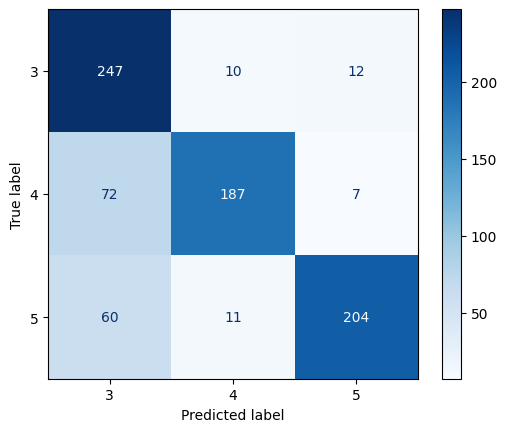

In [28]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

Finalmente, graficamos el árbol obtenido por el modelo

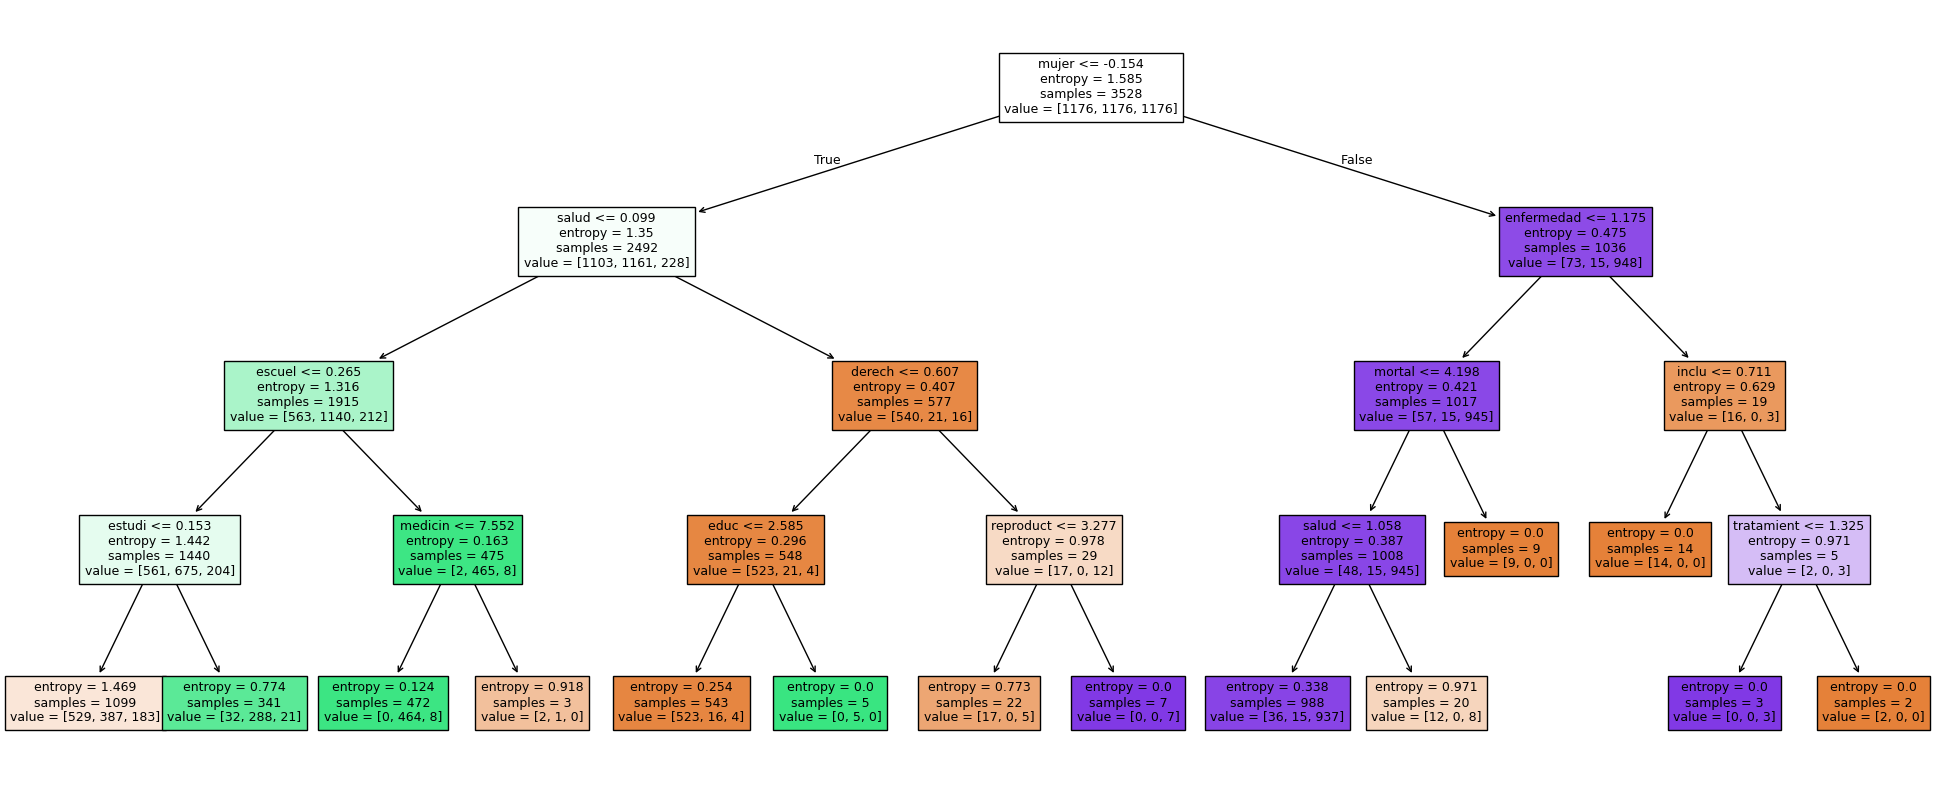

In [29]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol, max_depth=arbol.get_depth(), feature_names=X.columns,filled=True, fontsize=9)

### 4.1.1. Establecimiento de hiperparámetros

Como queremos mejorar el resultado anterior a pesar de ser bueno, buscamos los mejores hiperparámetros (criterion y max_depth) con búsqueda en grilla y con 10 particiones

In [30]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy'], 'max_depth':[8,10,12]}
arbol = DecisionTreeClassifier(random_state=0)
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
mejor_modelo.fit(X_smote, Y_smote)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 12}

Con estos nuevos parámetros, buscamos las métricas en entrenamiento y validación, buscando una mejora sin llegar a un sobreajuste

In [31]:
arbol_final = mejor_modelo.best_estimator_

y_pred_train = arbol_final.predict(X_smote)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train, average='macro')))
print(classification_report(Y_smote, y_pred_train))

y_pred_validation = arbol_final.predict(X_validation)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Precisión: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(classification_report(Y_validation, y_pred_validation))

ENTRENAMIENTO
Exactitud: 0.93
Recall: 0.9316893424036281
Precisión: 0.9363224172225069
Puntuación F1: 0.9323643473904438
              precision    recall  f1-score   support

           3       0.86      0.97      0.91      1176
           4       0.97      0.91      0.94      1176
           5       0.98      0.92      0.95      1176

    accuracy                           0.93      3528
   macro avg       0.94      0.93      0.93      3528
weighted avg       0.94      0.93      0.93      3528

VALIDACIÓN
Exactitud: 0.89
Recall: 0.8893151262746254
Precisión: 0.8932039688618637
Puntuación F1: 0.8892643315174458
              precision    recall  f1-score   support

           3       0.83      0.93      0.88       269
           4       0.92      0.90      0.91       266
           5       0.93      0.84      0.88       275

    accuracy                           0.89       810
   macro avg       0.89      0.89      0.89       810
weighted avg       0.89      0.89      0.89       810


Obtenemos la siguente matriz de confusión con el conjunto de validación

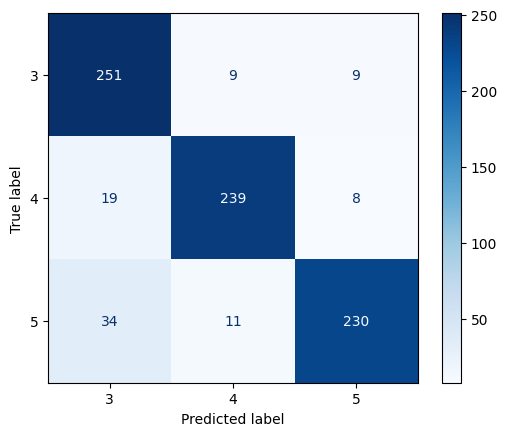

In [32]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol_final.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

Finalmente, graficamos el árbol definitivo obtenido por el modelo

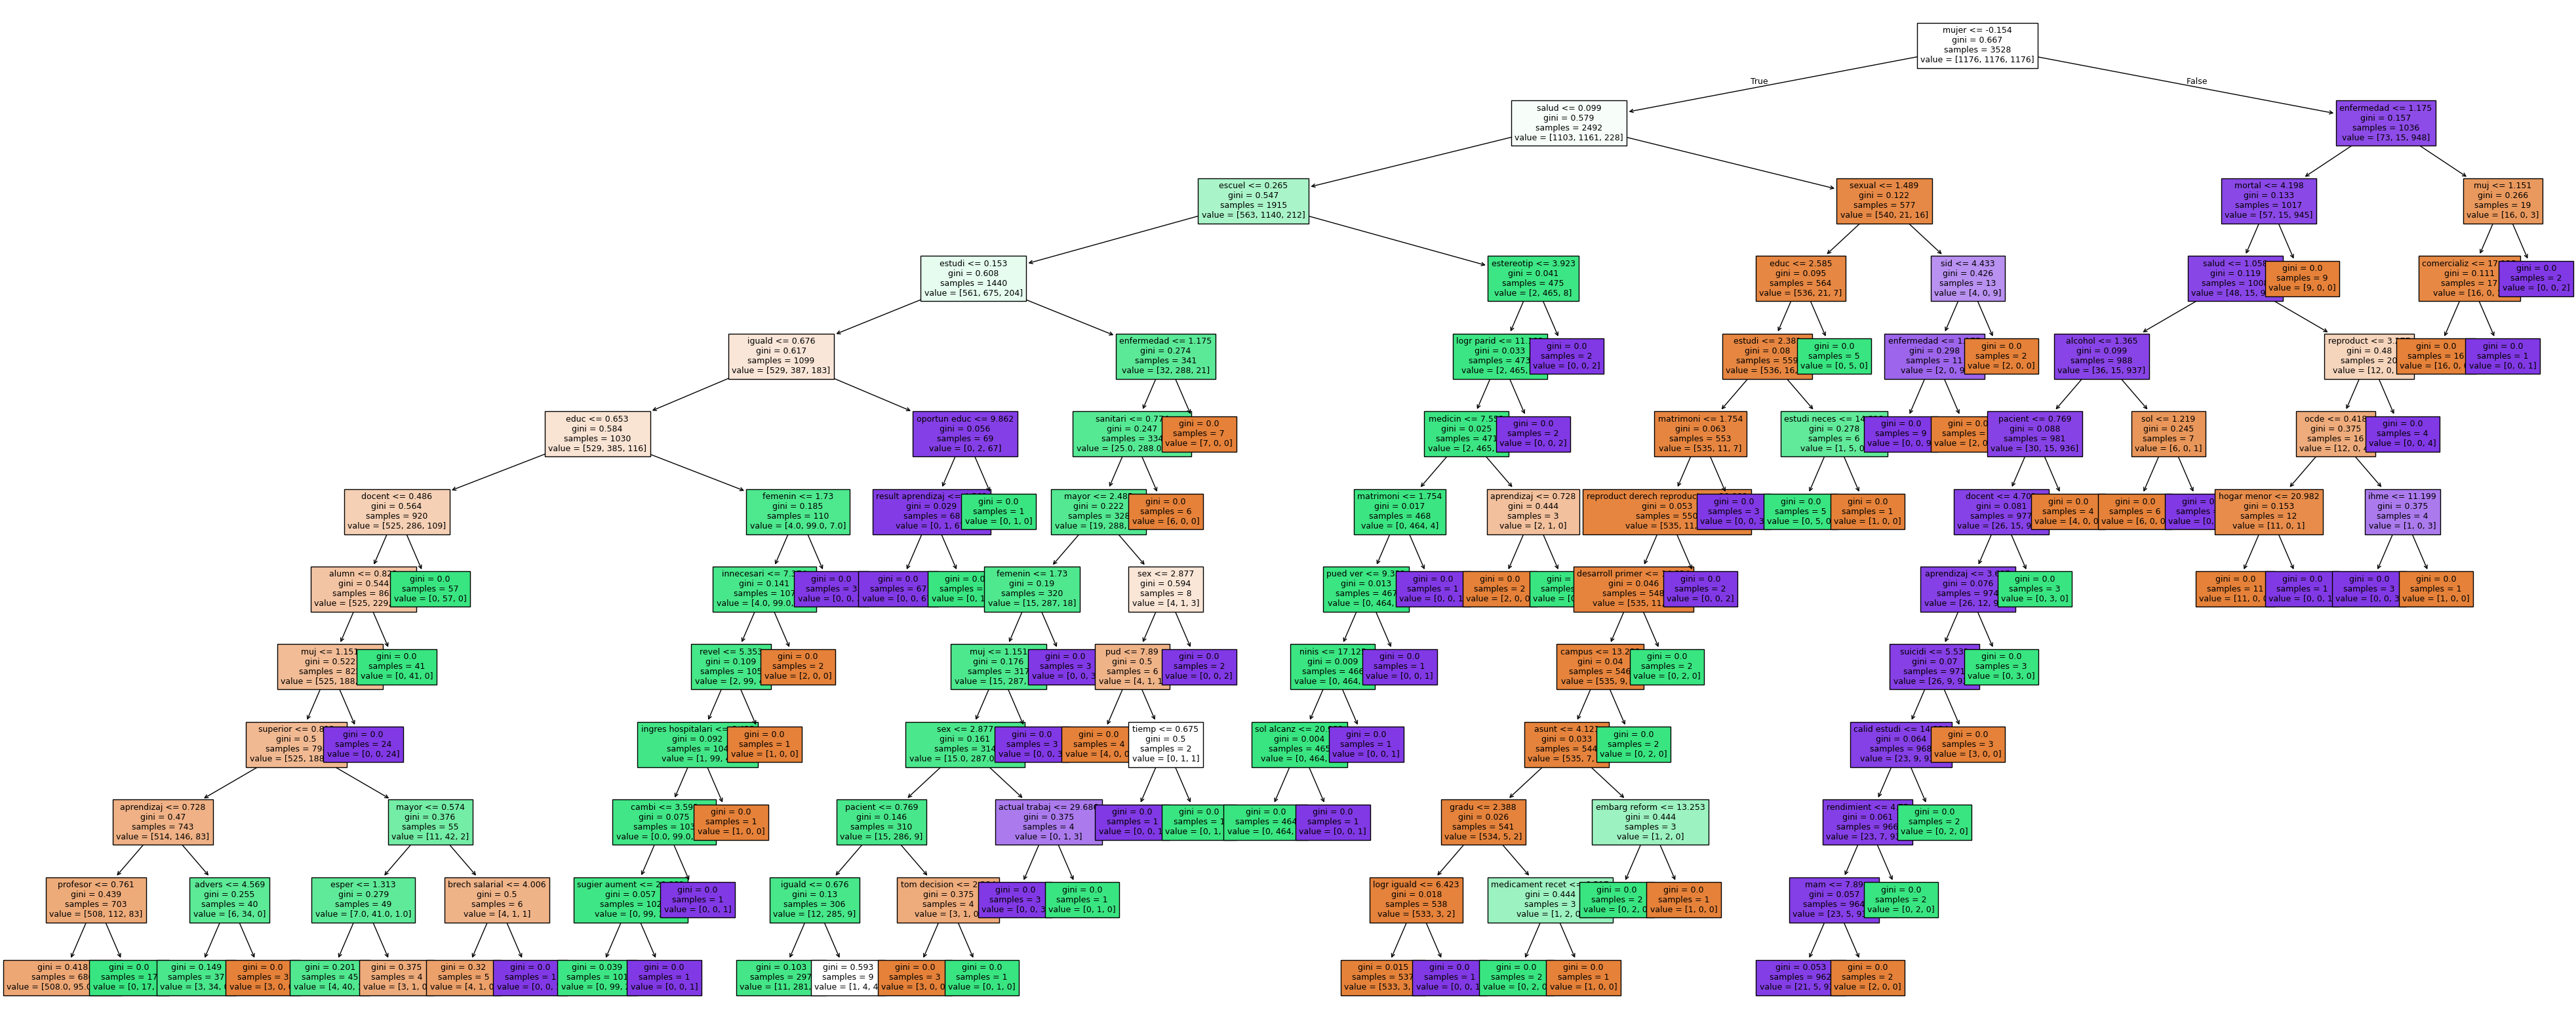

In [33]:
fig = plt.figure(figsize=(50,20))
_ = tree.plot_tree(arbol_final, max_depth=arbol_final.get_depth(), feature_names=X.columns,filled=True, fontsize=9)

## 4.2. K vecinos más cercanos

Este algoritmo fue implementado por Sara Cárdenas

Primero reducimos las dimensiones analizadas por el algoritmo, con el fin de manejar solo las variables más relevantes para el problema de clasificación

In [34]:
# Sumar los conteos de cada n-grama
conteos_smote = X_smote.sum(axis=0)

# Identificar las 4000 palabras (o n-gramas) más frecuentes
top_1500_conteos_smote = conteos_smote.nlargest(1500).index

# Filtrar el DataFrame para que solo contenga estas 5 columnas
X_smote_knn = X_smote[top_1500_conteos_smote].reindex(X_smote.index)
X_validation_knn = X_validation[top_1500_conteos_smote].reindex(X_validation.index)
X_smote_knn

,relacion,pued,inclus,inici,liger,muestr,ello,consider,logr,reduc,...,efect direct,effect,eficient sistem,ejempl muestr,embarg desarroll,embarg logr,embarg promedi,embarg sistem,emerg,empres mujer
0,-0.276550,-0.509893,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,2.833532,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
1,2.716296,3.566171,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,-0.290437,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
2,-0.276550,0.848795,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,-0.290437,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
3,-0.276550,-0.509893,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,-0.290437,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
4,-0.276550,-0.509893,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,-0.290437,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,-0.276550,-0.509893,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,-0.290437,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
3524,-0.276550,-0.509893,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,-0.290437,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
3525,-0.276550,-0.509893,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,2.833532,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691
3526,-0.276550,-0.509893,-0.219927,-0.21936,-0.104347,-0.236958,-0.097331,-0.290437,-0.256033,-0.237208,...,-0.033691,-0.033691,-0.047673,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691,-0.033691


Por defecto, implementamos un KNN con 3 vecinos entrenado sobre los conjuntos de SMOTE

In [35]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_smote_knn, Y_smote.values.ravel())

Estos son los resultados para el mismo conjunto de entrenamiento

In [36]:
y_pred_train = neigh.predict(X_smote_knn)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train, average='macro')))
print(classification_report(Y_smote, y_pred_train))

ENTRENAMIENTO
Exactitud: 0.76
Recall: 0.7559523809523809
Precisión: 0.8056314743824151
Puntuación F1: 0.7535920758760701
              precision    recall  f1-score   support

           3       0.62      0.94      0.75      1176
           4       0.87      0.78      0.82      1176
           5       0.92      0.55      0.69      1176

    accuracy                           0.76      3528
   macro avg       0.81      0.76      0.75      3528
weighted avg       0.81      0.76      0.75      3528



Estos son los resultados para el conjunto de validación

In [37]:
y_pred_validation = neigh.predict(X_validation_knn)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Precisión: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(classification_report(Y_validation, y_pred_validation))

VALIDACIÓN
Exactitud: 0.53
Recall: 0.53227680556579
Precisión: 0.5898242831503818
Puntuación F1: 0.4970998843381274
              precision    recall  f1-score   support

           3       0.46      0.83      0.59       269
           4       0.62      0.58      0.60       266
           5       0.69      0.20      0.31       275

    accuracy                           0.53       810
   macro avg       0.59      0.53      0.50       810
weighted avg       0.59      0.53      0.50       810



Obtenemos la siguente matriz de confusión con el conjunto de validación

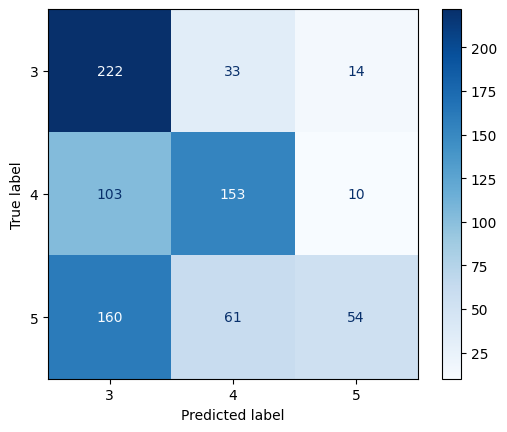

In [38]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

### 4.2.1. Establecimiento de hiperparámetros


Como queremos mejorar el resultado anterior a pesar de ser bueno, buscamos los mejores hiperparámetros (n_neighbors y weights) con búsqueda en grilla y con 10 particiones. Como métrica, usamos la precisión, ya que esta ha sido la más afectada y necesita prioridad por el problema

In [39]:
param_grid = {"n_neighbors": [3,5,7], "weights": ['uniform', 'distance']}
neigh = KNeighborsClassifier()
particiones = KFold(n_splits=10, shuffle=True, random_state=0)
mejor_modelo = GridSearchCV(neigh, param_grid, cv=particiones)
mejor_modelo.fit(X_smote_knn, Y_smote.values.ravel())
mejor_modelo.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

Con estos nuevos parámetros, buscamos las métricas en entrenamiento y validación, buscando una mejora sin llegar a un sobreajuste

In [40]:
knn_final = mejor_modelo.best_estimator_

y_pred_train = knn_final.predict(X_smote_knn)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train, average='macro')))
print(classification_report(Y_smote, y_pred_train))

y_pred_validation = knn_final.predict(X_validation_knn)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Precisión: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(classification_report(Y_validation, y_pred_validation))

ENTRENAMIENTO
Exactitud: 1.00
Recall: 0.9951814058956915
Precisión: 0.995250069851914
Puntuación F1: 0.9951811541475681
              precision    recall  f1-score   support

           3       0.99      1.00      0.99      1176
           4       1.00      0.99      0.99      1176
           5       1.00      1.00      1.00      1176

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528

VALIDACIÓN
Exactitud: 0.53
Recall: 0.5356716732690124
Precisión: 0.5570600805383474
Puntuación F1: 0.51063611363447
              precision    recall  f1-score   support

           3       0.48      0.77      0.59       269
           4       0.59      0.59      0.59       266
           5       0.60      0.25      0.35       275

    accuracy                           0.53       810
   macro avg       0.56      0.54      0.51       810
weighted avg       0.56      0.53      0.51       810



Obtenemos la siguente matriz de confusión con el conjunto de validación

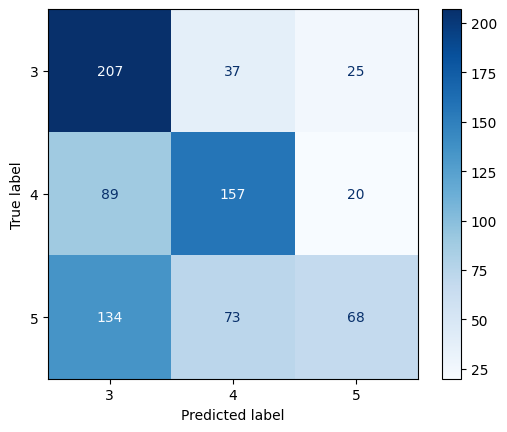

In [41]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_final.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

## 4.3. Clasificador Gradient Boosting

Este algoritmo fue implementado por Juan Sebastián Urrea López

El Gradient Boosting es un algoritmo de ensamble que combina varios árboles de decisión débiles (árboles con baja profundidad) para mejorar su precisión y evitar sobreajuste. Este método funciona entrenando secuencialmente los árboles, donde cada nuevo árbol trata de corregir los errores cometidos por el conjunto de árboles anteriores.

Por defecto, implementamos un Gradient Boosting con 100 estimadores y una profundidad de 3 entrenado sobre los conjuntos de SMOTE

In [54]:
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
gb_clf = gb_clf.fit(X_smote, Y_smote.values.ravel())

Estos son los resultados para el mismo conjunto de entrenamiento:

In [43]:
y_pred_train = gb_clf.predict(X_smote)

print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train, average='macro')))
print(classification_report(Y_smote, y_pred_train))

ENTRENAMIENTO
Exactitud: 0.97
Recall: 0.9705215419501134
Precisión: 0.9707349326008465
Puntuación F1: 0.9705554991977703
              precision    recall  f1-score   support

           3       0.95      0.98      0.97      1176
           4       0.98      0.96      0.97      1176
           5       0.98      0.97      0.98      1176

    accuracy                           0.97      3528
   macro avg       0.97      0.97      0.97      3528
weighted avg       0.97      0.97      0.97      3528



Estos son los resultados para el conjunto de validación:

In [55]:
y_pred_validation = gb_clf.predict(X_validation)

print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Precisión: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(classification_report(Y_validation, y_pred_validation))

VALIDACIÓN
Exactitud: 0.93
Recall: 0.9348720398495395
Precisión: 0.9352382303403034
Puntuación F1: 0.9345470476246724
              precision    recall  f1-score   support

           3       0.91      0.96      0.94       269
           4       0.94      0.94      0.94       266
           5       0.95      0.90      0.93       275

    accuracy                           0.93       810
   macro avg       0.94      0.93      0.93       810
weighted avg       0.94      0.93      0.93       810



Obtenemos la siguente matriz de confusión con el conjunto de validación:

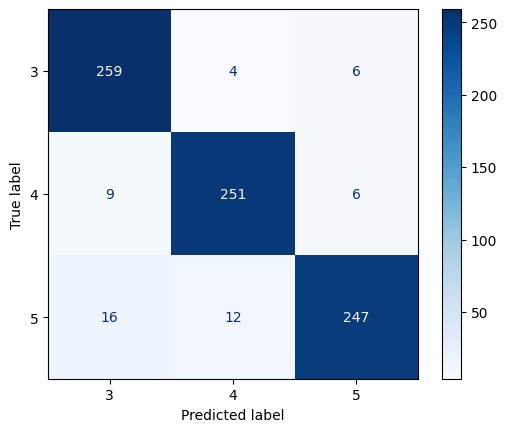

In [45]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### 4.3.1. Establecimiento de hiperparámetros


Para mejorar el resultado, buscamos los mejores hiperparámetros como el número de estimadores y la profundidad máxima de los árboles en Gradient Boosting. Para esto, usamos la búsqueda en grilla con 10 particiones. Como métrica, usamos la precisión, ya que esta ha sido la más afectada y necesita prioridad por el problema.

In [50]:
param_grid = {'n_estimators': [100, 300], 'max_depth': [3, 5]}
gb_clf = GradientBoostingClassifier(random_state=0)
particiones = KFold(n_splits=10, shuffle=True, random_state=0)
mejor_modelo = GridSearchCV(gb_clf, param_grid, cv=particiones)
mejor_modelo.fit(X_smote, Y_smote.values.ravel())
mejor_modelo.best_params_

{'n_estimators': 100, 'max_depth': 3}


Con estos nuevos parámetros, buscamos las métricas en entrenamiento y validación, buscando una mejora sin llegar a un sobreajuste.

In [57]:
gb_final = mejor_modelo.best_estimator_

y_pred_train = gb_final.predict(X_smote)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train, average='macro')))
print(classification_report(Y_smote, y_pred_train))

y_pred_validation = gb_final.predict(X_validation)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_validation, y_pred_validation))
print("Recall: {}".format(recall_score(Y_validation, y_pred_validation, average='macro')))
print("Precisión: {}".format(precision_score(Y_validation, y_pred_validation, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_validation, y_pred_validation, average='macro')))
print(classification_report(Y_validation, y_pred_validation))

ENTRENAMIENTO
Exactitud: 0.97
Recall: 0.9705215419501134
Precisión: 0.9707349326008465
Puntuación F1: 0.9705554991977703
              precision    recall  f1-score   support

           3       0.95      0.98      0.97      1176
           4       0.98      0.96      0.97      1176
           5       0.98      0.97      0.98      1176

    accuracy                           0.97      3528
   macro avg       0.97      0.97      0.97      3528
weighted avg       0.97      0.97      0.97      3528

VALIDACIÓN
Exactitud: 0.93
Recall: 0.9348720398495395
Precisión: 0.9352382303403034
Puntuación F1: 0.9345470476246724
              precision    recall  f1-score   support

           3       0.91      0.96      0.94       269
           4       0.94      0.94      0.94       266
           5       0.95      0.90      0.93       275

    accuracy                           0.93       810
   macro avg       0.94      0.93      0.93       810
weighted avg       0.94      0.93      0.93       810


Obtenemos la siguente matriz de confusión con el conjunto de validación:

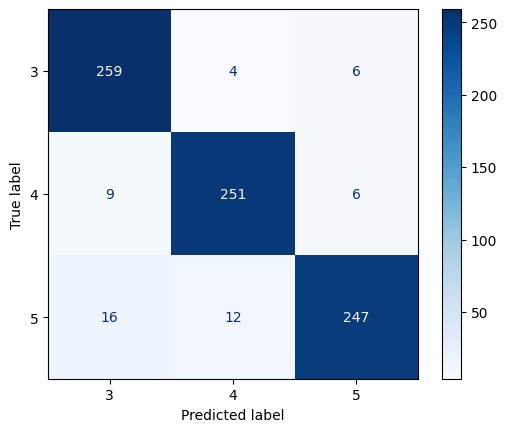

In [58]:
cm = confusion_matrix(Y_validation, y_pred_validation)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_final.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

## 6. Persistencia del modelo

Ahora sí, podemos persistir el modelo y la preparación de datos

In [59]:
# Definir las funciones de preprocesamiento fuera del pipeline

def text_preprocessing_function(x):
    return x.apply(procesar)

def vectorization_function(x):
    return pd.DataFrame(bv.transform(x).toarray(), columns=bv.get_feature_names_out())

def scaling_function(x):
    return pd.DataFrame(scaler.transform(x), columns=bv.get_feature_names_out())

# Crear un pipeline para el procesamiento del texto, la transformación del conjunto de test y la clasificación
pipeline = Pipeline([
    # Paso 1: Preprocesar el texto
    ('text_preprocessing', FunctionTransformer(text_preprocessing_function)),

    # Paso 2: Vectorizar el texto (usando el vectorizador preentrenado)
    ('vectorization', FunctionTransformer(vectorization_function)),

    # Paso 3: Escalar las características (usando el escalador preentrenado)
    ('scaling', FunctionTransformer(scaling_function)),

    # Paso 4: Clasificar el texto 
    ('classification', gb_final) 
])

dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [62]:
# Cargar el pipeline preentrenado
pipeline = load('pipeline.joblib')

# Predecir las etiquetas del conjunto de test
y_pred_test = pipeline.predict(opiniones_test_df["Textos_espanol"])

# y_pred_test contiene las predicciones del conjunto de test
print(y_pred_test)

# Unir las predicciones con el conjunto de test
opiniones_test_df['sdg'] = y_pred_test

# Generar un archivo CSV con las predicciones
opiniones_test_df.to_csv('Proyecto 1 - Predicciones sobre test.csv', index=False)

[4 3 4 3 4 3 4 3 4 4 4 3 3 3 3 3 4 4 3 4 3 4 3 3 4 3 4 3 4 4 3 4 3 4 3 4 3
 4 3 4 4 4 4 4 3 4 3 4 3 3 4 3 4 4 4 4 3 4 3 4 4 3 3 3 5 3 3 3 5 5 3 4 4 4
 4 5 4 5 4 4 3 3 3 5 4 4 4 4 4 5 5 4 4 5 5 5 5 4 5 4 5 3 5 3 4 5 5 3 4 4 4
 4 5 4 4 5 5 5 5 4 3 3 4 5 3 4 5 5 4 4 3 4 4 5 3 4 3 4 3 4 5 5 5 4 4 4 3 3
 3 4 5 3 5 3 5 3 4 4 4 4 4 5 3 4 5 3 3 3 4 5 4 4 5 4 4 3 4 3 3 4 5 3 4 3 5
 4 5 5 4 5 3 5 5 4 3 4 4 5 3 4 4 4 4 5 5 3 4 4 5 3 4 4 5 5 3 5 3 3 5 5 4 4
 4 4 4 5 3 3 5 4 4 3 5 5 3 4 5 5 4 5 3 3 3 4 5 4 5 4 5 4 5 4 4 3 3 5 4 4 3
 4 5 4 5 3 4 3 4 4 4 5 4 5 3 4 4 5 4 5 3 3 5 3 5 5 5 3 4 5 3 3 4 4 5 3 5 4
 4 3 5 3 3 3 3 5 3 3 5 5 4 4 5 4 3 3 3 5 4 5 4 3 4 3 5 3 5 3 3 4 5 3 3 3 5
 3 4 5 3 4 3 4 3 5 3 4 4 4 5 3 4 3 4 3 3 4 3 5 5 5 4 3 5 5 5 4 5 3 3 4 5 3
 3 4 4 5 5 4 4 5 4 4 4 5 3 4 5 5 5 4 3 5 3 5 3 3 3 3 4 3 5 3 5 5 5 5 4 4 3
 3 4 3 4 5 3 5 4 5 4 4 4 4 4 3 4 5 4 5 4 4 3 5 3 4 5 4 5 5 3 5 4 5 4 4 4 3
 3 4 4 5 5 3 5 4 5 3 4 5 5 5 3 5 3 4 4 3 4 5 4 5 4 3 5 4 4 3 5 4 5 3 5 3 4
 5 3 5 4 5 4 3 3 3 5 5 5 